#### 0. Imports and settings

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, warnings
from scipy import integrate
warnings.filterwarnings('ignore')

path = os.getcwd()
datapath = path+'/Data/Final'
outputpath = path+'/Figures'
sns.set_style('darkgrid')
redpalette = sns.color_palette("YlOrRd",9)
bluepalette = sns.color_palette("PuBu",9)
greenpalette = sns.color_palette('Greens',9)

df = pd.read_csv(path+'/predator-prey-data.csv')
t = df.values[:,0]
data = (df.values[:,1],df.values[:,2])


In [193]:
#Settings for graph
plt.rcParams['xtick.labelsize']= 20
plt.rcParams['ytick.labelsize']= 20
plt.rcParams['axes.labelsize']= 22
plt.rcParams['lines.linewidth']= 2
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["legend.fontsize"] = 22

#### 1. Plot cooling schedules and datapoints

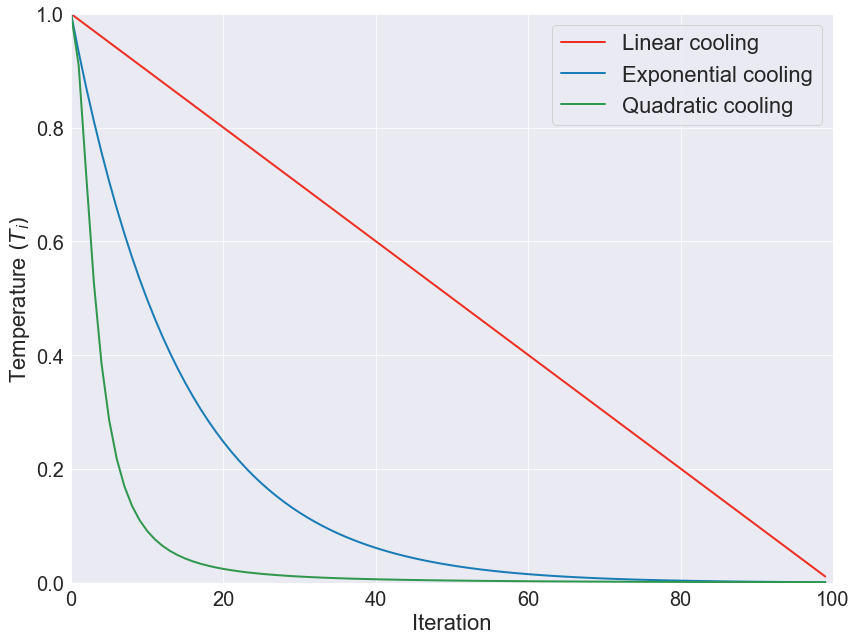

In [194]:
temp0 = 1
temp_end = 10**(-3)
T_lin, T_exp, T_quad = [temp0,], [temp0], [temp0]
rate1 = (temp0-temp_end)/(100)
rate2 = (temp_end / temp0) ** (1 / (100 - 1))
alpha = (temp0 / temp_end - 1) / (100) ** 2

for i in range(99):
    T_lin.append(T_lin[i] - rate1)
    T_exp.append(T_exp[i]*rate2)
    T_quad.append(temp0 / (1 + alpha * (i+1) ** 2))


fig,ax = plt.subplots(1)
ax.plot(np.arange(100),T_lin,label='Linear cooling',color=redpalette[6])
ax.plot(np.arange(100),T_exp,label='Exponential cooling',color=bluepalette[6])
ax.plot(np.arange(100),T_quad,label='Quadratic cooling',color=greenpalette[6])
ax.set_xlabel('Iteration')
ax.set_ylabel(r'Temperature $(T_i)$')
ax.set_xlim((0,100))
ax.set_ylim((0,1))
ax.legend()
fig.show()
fig.tight_layout()     
plt.savefig(outputpath+'/coolingschedules.pdf',dpi=300)




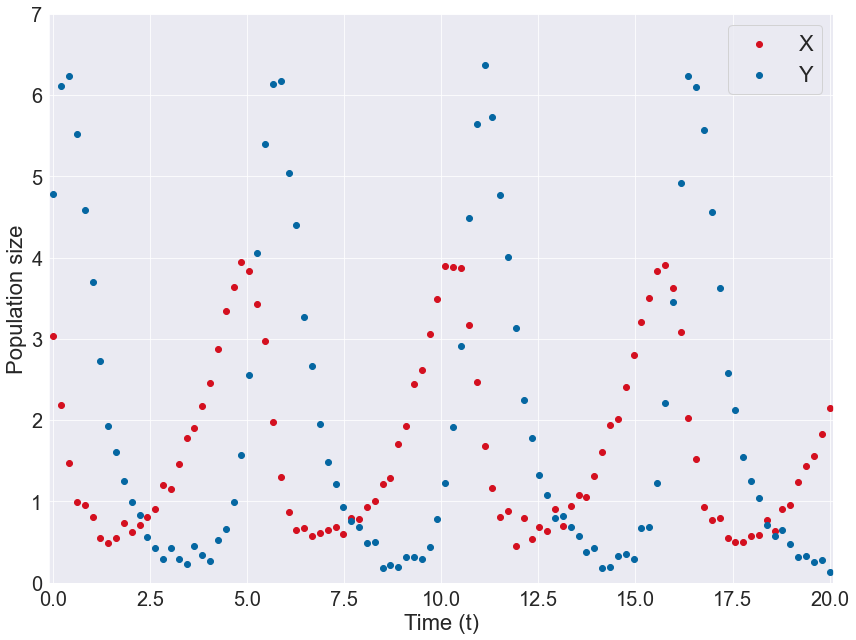

In [195]:
fig,ax = plt.subplots(1)
ax.scatter(t,data[0],label='X',color=redpalette[7])
ax.scatter(t,data[1],label='Y',color=bluepalette[7])
ax.set_xlim((-0.1,20.1))
ax.set_ylim((0,7))
ax.set_xlabel('Time (t)')
ax.set_ylabel('Population size')
ax.legend()
fig.show()
fig.tight_layout()     
plt.savefig(outputpath+'/datascatter.pdf',dpi=300)

#### 2. Hill climber starting points
- First define function to integrate via Scipy
- Define initial values (that we have from data)
- Use parameters from Hill Climbing to estimate models


In [196]:
def get_ODE(data, t, alpha, beta, gamma, delta):
    """Returns set of ODE's for given data and params."""

    # data should be array-like of prey and predator quantities respectively
    # params should be array-like of 4 params (alpha, beta, gamma, delta)
    x, y = data[0], data[1]
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

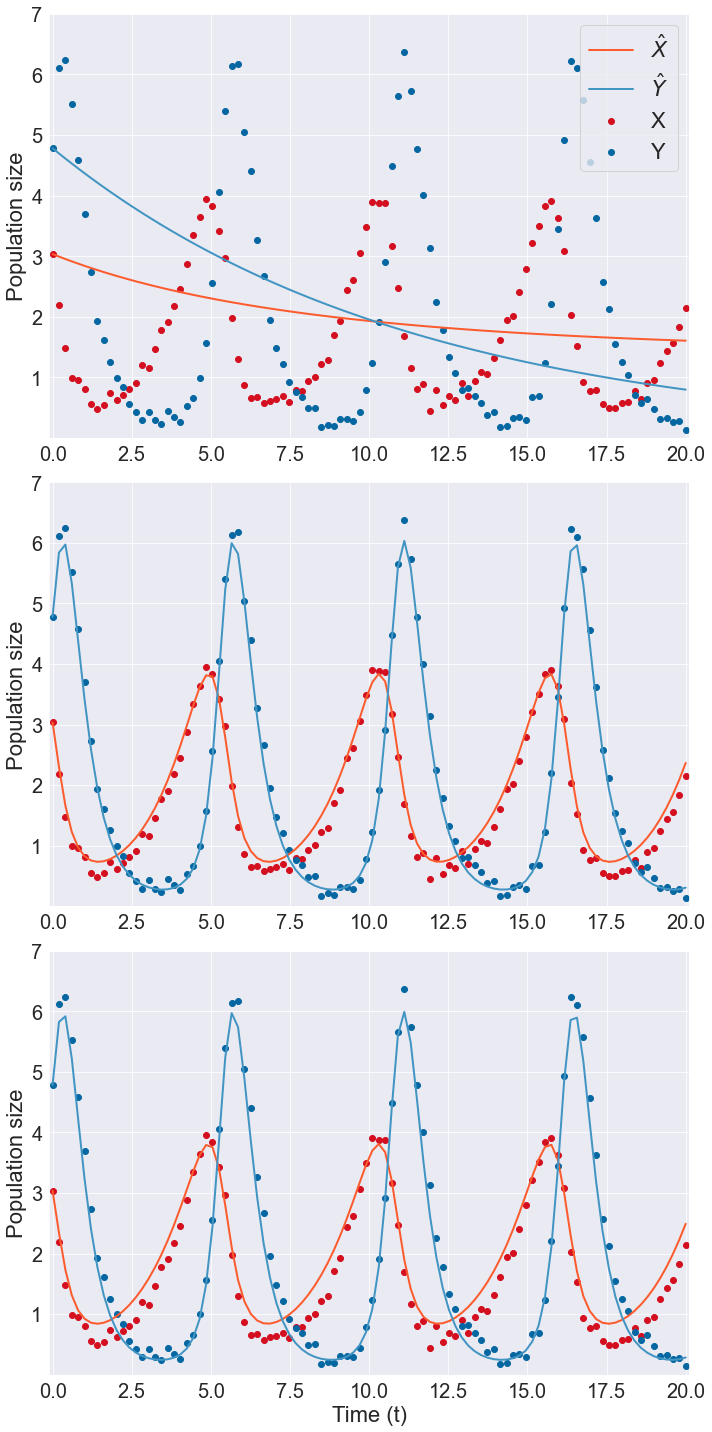

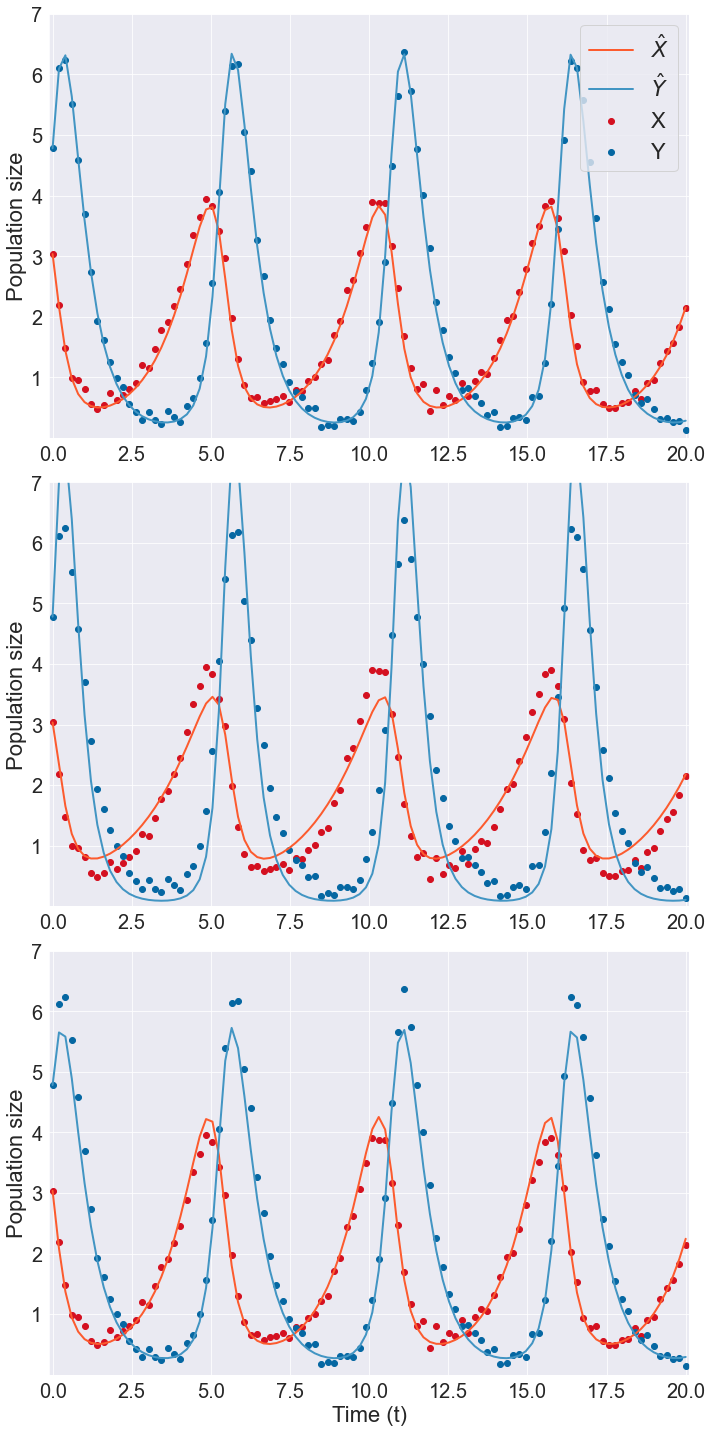

In [197]:
start = np.array([data[0][0],data[1][0]])
showcolumns = ['HC05','HC_start1','HC_start2']

for evalfunc in ['RMSE', 'MAE']:
    df_params = pd.read_csv(datapath+'/'+evalfunc+'-params.csv',index_col=0)
    fig,ax = plt.subplots(3,figsize=(10,20))
    for i in range(len(showcolumns)):
        ax[i].scatter(t,data[0],label='X',color=redpalette[7])
        ax[i].scatter(t,data[1],label='Y',color=bluepalette[7]) 
        fit = integrate.odeint(get_ODE, start, t, args=tuple(df_params[showcolumns[i]]))
        ax[i].plot(t,fit[:,0], label=r'$\hat{X}$',color=redpalette[5])
        ax[i].plot(t,fit[:,1], label=r'$\hat{Y}$',color=bluepalette[5])
        ax[i].set_xlim((-0.1,20.1))
        ax[i].set_ylim((0,7))
        ax[i].set_yticks(np.arange(1,8))

        ax[i].set_ylabel('Population size')
    ax[2].set_xlabel('Time (t)')
    ax[0].legend()
    fig.show()
    fig.tight_layout()
    plt.savefig(outputpath+'/HCfits-'+evalfunc+'.pdf',dpi=300)

#### 3. Experiment with SA parameters
- Vary stepsize, Markov Chain length, cooling schedule and initial temperature
- Use this to determine optimal settings

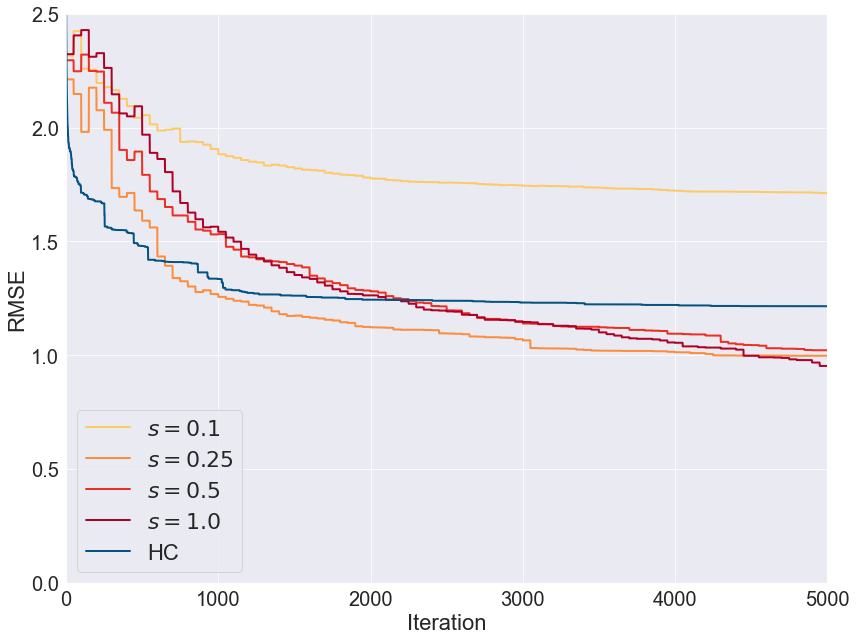

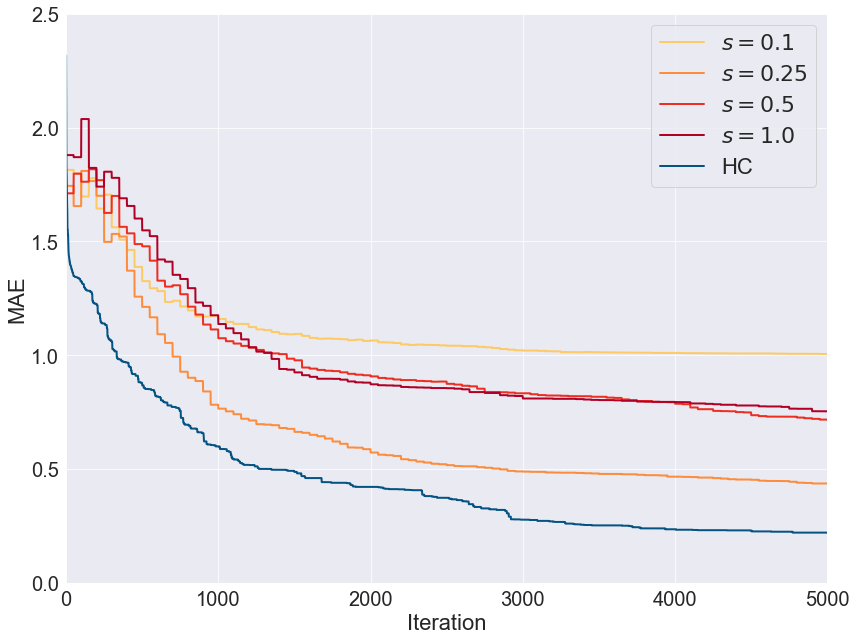

In [198]:
showcolumns = ['SA01','SA025','SA05','SA10','HC05']
modelnames = [r'$s = 0.1$',r'$s = 0.25$',r'$s = 0.5$',r'$s = 1.0$','HC']

for evalfunc in ['RMSE','MAE']:
    df_conv = pd.read_csv(datapath+'/'+evalfunc+'-conv.csv',index_col=0)
    fig,ax = plt.subplots(1)
#     ax.plot(np.arange(5000),df_conv['HC05'],label='Hill Climber',color='k')
    for i in range(len(showcolumns)):
        if i < 4:
            color = redpalette[2*i+2]
        elif i < 6:
            color = bluepalette[8]
        ax.plot(np.arange(5000),df_conv[showcolumns[i]],label=modelnames[i],color=color)
        ax.set_xlim((0,5000))
        if evalfunc == 'RMSE':
            ax.set_ylabel('RMSE')
            ax.set_ylim((0,2.5))
        else:
            ax.set_ylabel('MAE')
            ax.set_ylim((0,2.5))

        ax.set_xlabel('Iteration')
    if evalfunc == 'RMSE':
        ax.legend(ncol=1,loc='lower left')
    else:
        ax.legend(ncol=1,loc='upper right')

    fig.show()
    fig.tight_layout()
    plt.savefig(outputpath+'/SAconv-stepsize-'+evalfunc+'.pdf',dpi=300)

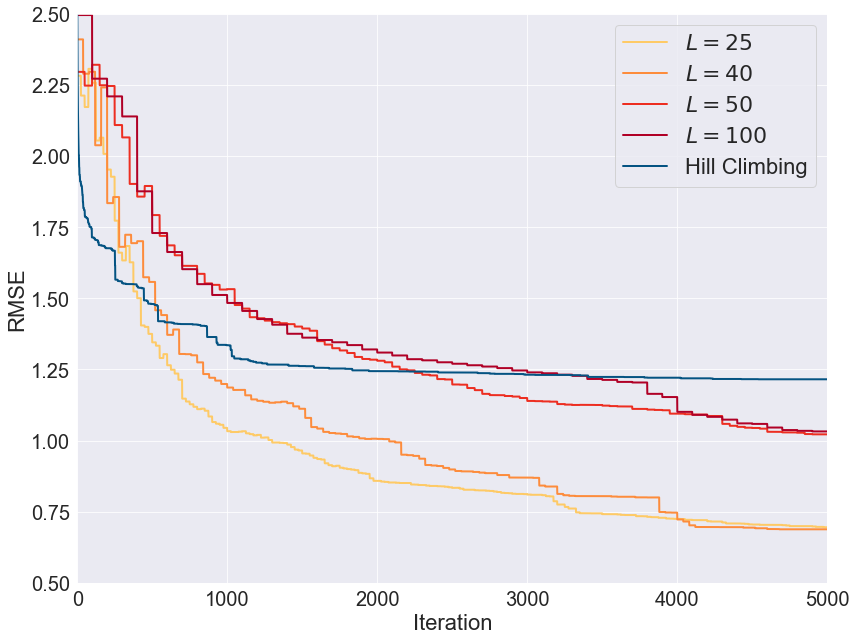

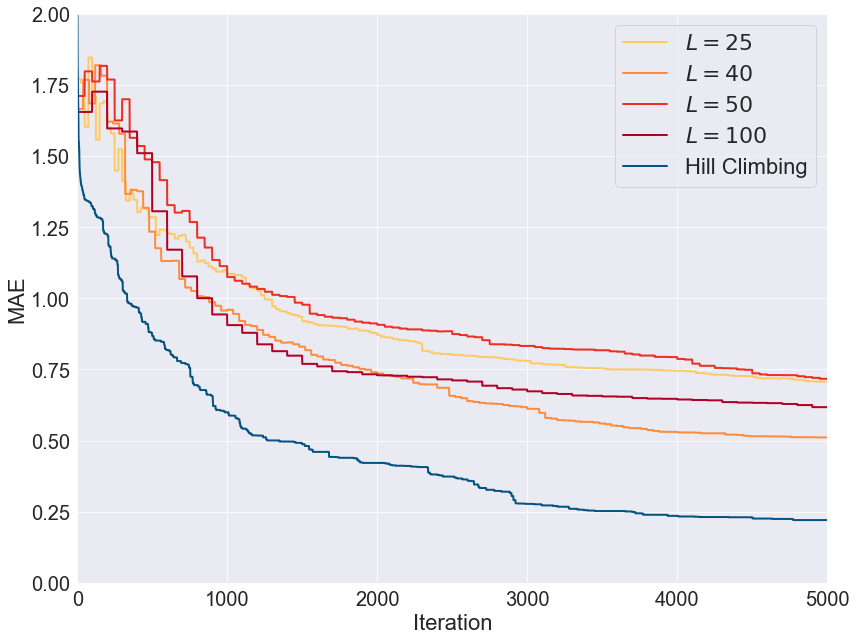

In [199]:
showcolumns = ['SA25','SA40','SA05','SA100','HC05']
modelnames = [r'$L = 25$', r'$L = 40$', r'$L = 50$',r'$L = 100$','Hill Climbing']

for evalfunc in ['RMSE', 'MAE']:
    df_conv = pd.read_csv(datapath+'/'+evalfunc+'-conv.csv',index_col=0)
    fig,ax = plt.subplots(1)
    for i in range(len(showcolumns)):
        if i < 4:
            color = redpalette[2*i+2]
        elif i < 6:
            color = bluepalette[8]
        elif i < 8:
            color = greenpalette[(i-6)*5+3]
        ax.plot(np.arange(5000),df_conv[showcolumns[i]],label=modelnames[i],color=color)
        ax.set_xlim((0,5000))
        if evalfunc == 'RMSE':
            ax.set_ylabel('RMSE')
            ax.set_ylim((0.5,2.5))
        else:
            ax.set_ylabel('MAE')
            ax.set_ylim((0,2))

        ax.set_xlabel('Iteration')
    ax.legend(ncol=1)
    fig.show()
    fig.tight_layout()
    plt.savefig(outputpath+'/SAconv-L-'+evalfunc+'.pdf',dpi=300)

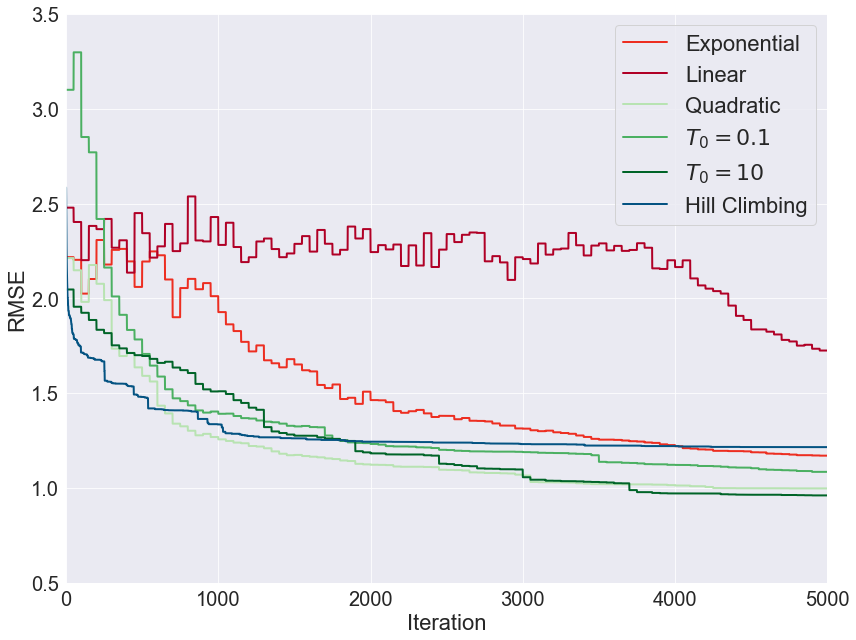

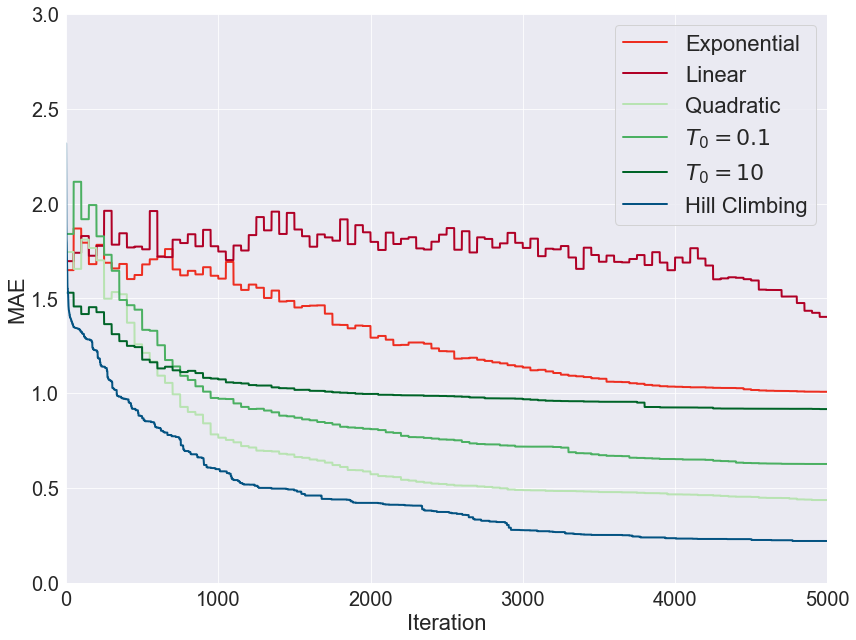

In [200]:
showcolumns = ['SA_exp','SA_lin','SA025','SA_init10','SA_init01','HC05']
modelnames = ['Exponential','Linear','Quadratic',
              r'$T_0 = 0.1$', r'$T_0 = 10$','Hill Climbing']

for evalfunc in ['RMSE', 'MAE']:
    df_conv = pd.read_csv(datapath+'/'+evalfunc+'-conv.csv',index_col=0)
    fig,ax = plt.subplots(1)
    for i in range(len(showcolumns)):
        if i < 2:
            color = redpalette[2*i+6]
        elif i < 5:
            color = greenpalette[(i-2)*3 +2]
        elif i < 7:
            color = bluepalette[8]
        ax.plot(np.arange(5000),df_conv[showcolumns[i]],label=modelnames[i],color=color)
        ax.set_xlim((0,5000))
        if evalfunc == 'RMSE':
            ax.set_ylabel('RMSE')
            ax.set_ylim((0.5,3.5))
        else:
            ax.set_ylabel('MAE')
            ax.set_ylim((0,3))

        ax.set_xlabel('Iteration')
    ax.legend(ncol=1)
    fig.show()
    fig.tight_layout()
    plt.savefig(outputpath+'/SAconv-cooling-'+evalfunc+'.pdf',dpi=300)

#### 4. Overview of all parameters and evaluations

In [201]:
df_MAE = pd.read_csv(datapath+'/MAE.csv',index_col=0)
df_RMSE = pd.read_csv(datapath+'/RMSE.csv',index_col=0)
df_stats = pd.DataFrame(np.mean(df_RMSE),columns=['RMSE'])
df_stats['sigma1'] = np.std(df_RMSE)
df_stats['MAE'] = np.mean(df_MAE)
df_stats['sigma2'] = np.std(df_MAE)
columns = ['SA40','SA10','HC05','SA025']
df_stats = df_stats.loc[columns,:]
df_stats.sort_values(by='RMSE',inplace=True)
df_stats.index = ['L = 40','s = 1.0','L = 50','HC']
df_stats = round(df_stats,3)
df_stats

,RMSE,sigma1,MAE,sigma2
L = 40,0.688,0.734,0.511,0.426
s = 1.0,0.953,0.443,0.754,0.280
L = 50,0.998,0.815,0.436,0.453
HC,1.215,0.679,0.221,0.221


In [202]:
from scipy import stats
print('F 0.95: {}'.format(round(stats.f.ppf(q=0.95,dfn=25-1,dfd=25-1),4)))
print('F 0.99: {}'.format(round(stats.f.ppf(q=0.99,dfn=25-1,dfd=25-1),4)))

var0 = df_stats.loc['L = 40','sigma1']**2
var1 = df_stats.loc['s = 1.0','sigma1']**2
F_RMSE = var0/var1
var0 = df_stats.loc['L = 40','sigma2']**2
var1 = df_stats.loc['s = 1.0','sigma2']**2
F_MAE = var0/var1
print('F for RMSE vars: {}'.format(F_RMSE))
print('F for MAE vars: {}'.format(F_MAE))

F 0.95: 1.9838
F 0.99: 2.6591
F for RMSE vars: 2.7452674918088755
F for MAE vars: 2.314744897959183


#### 5. Alternatives for full data use
- First show decreasing percentage of data use against performance, for both models and both evaluations
- Then show table of random data removal compared to peaks and bottoms removed

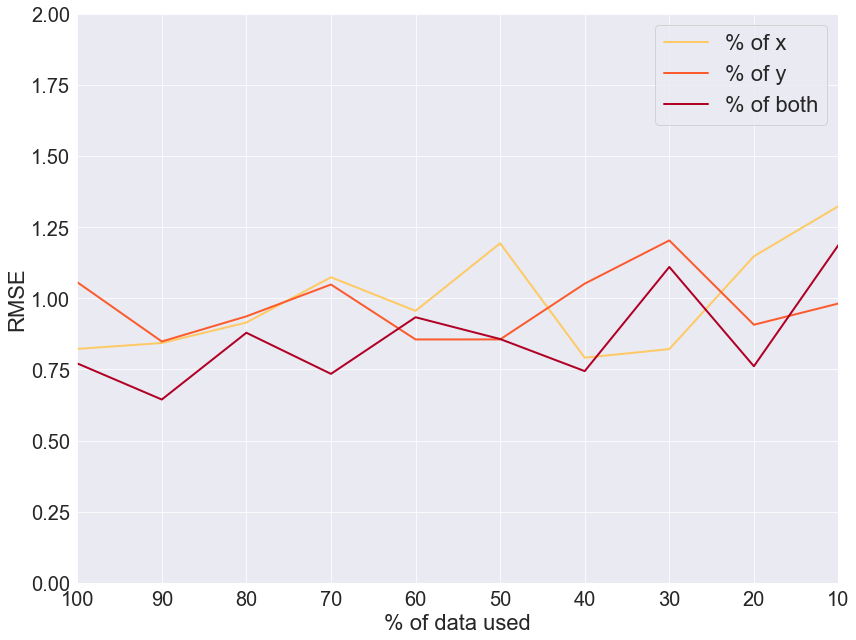

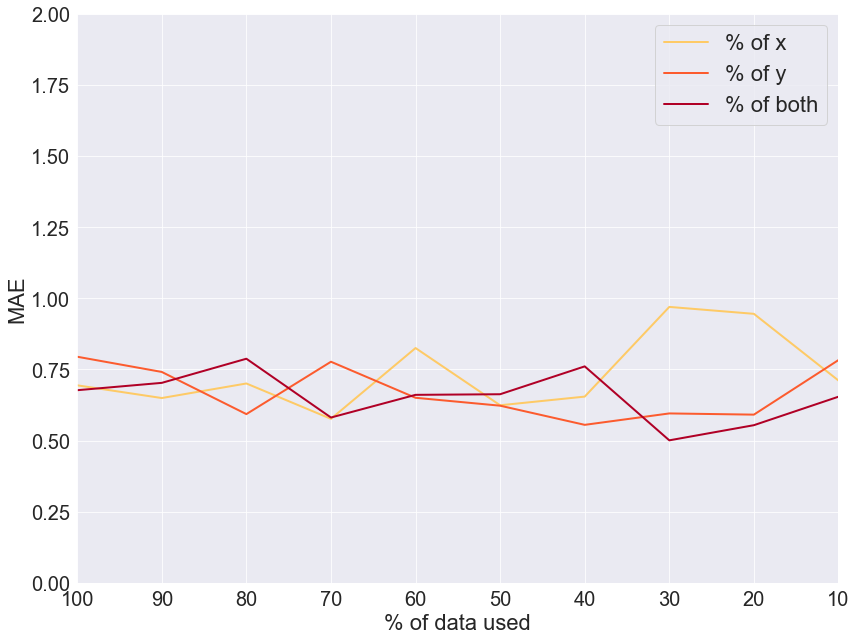

In [203]:
perc = np.arange(1,0,-0.1)

for evalfunc in ['RMSE','MAE']:
    fig,ax = plt.subplots(1)
    palette_index = 2
    for less in ['lessx','lessy','lessboth']:
        df_less = pd.read_csv(datapath+'/fracdata-'+less+'-'+evalfunc+'.csv',index_col=0)
        ax.plot(perc, df_less['SA_mean'],color=redpalette[palette_index])
        palette_index += 3
    ax.set_xlim((1,0.1))
    ax.set_xticklabels(np.arange(10,110,10))
    ax.set_ylim((0,2))
    if evalfunc == 'RMSE':
        ax.set_ylabel('RMSE')
    else:
        ax.set_ylabel('MAE')
    ax.set_xlabel('% of data used')
    ax.legend(['% of x','% of y', '% of both'])
    fig.show()
    fig.tight_layout()
    plt.savefig(outputpath+'/lessdata-'+evalfunc+'.pdf',dpi=300)

In [204]:
df_stats = pd.read_csv(datapath+'/fracdata-onlypeaks-RMSE.csv',index_col=0)[['SA_mean','SA_std']]
df_stats.rename(index={0: 'Peaks only'}, columns={"SA_mean": "RMSE mean", "SA_std": "RMSE std"},inplace=True)


df_stats = pd.DataFrame({})
for evalfunc in ['RMSE','MAE']:
    if evalfunc == 'RMSE':
        for less in ['lessx','lessy','lessboth','onlypeaks','nopeaks']:
            df_less = pd.read_csv(datapath+'/fracdata-'+less+'-'+evalfunc+'.csv',index_col=0)
            if less not in ['onlypeaks','nopeaks']:
                df_stats = df_stats.append([df_less[['SA_mean','SA_std']].iloc[3]])
            else:
                df_stats = df_stats.append([df_less[['SA_mean','SA_std']]])
    else:
        for less in ['lessx','lessy','lessboth','onlypeaks','nopeaks']:
            df_less = pd.read_csv(datapath+'/fracdata-'+less+'-'+evalfunc+'.csv',index_col=0)
            if less not in ['onlypeaks','nopeaks']:
                df_stats = df_stats.append([df_less[['SA_mean','SA_std']].iloc[3]])
            else:
                df_stats = df_stats.append([df_less[['SA_mean','SA_std']]])
df_stats.columns = ['Mean','Std.']
df_stats.index = ['Less X (RMSE)','Less Y (RMSE)','Less all (RMSE)','Only peaks (RMSE)',
                  'No peaks (RMSE)','Less X (MAE)','Less Y (MAE)','Less all (MAE)','Only peaks (MAE)',
                 'No peaks (MAE)']
# df_stats.sort_values(by='Mean',inplace=True)
df_RMSEstats = df_stats[0:5].sort_values(by='Mean')
df_MAEstats = df_stats[5:10].sort_values(by='Mean')

df_RMSEstats


,Mean,Std.
No peaks (RMSE),0.667380,0.069878
Less all (RMSE),0.734530,0.718964
Only peaks (RMSE),1.042169,0.021509
Less Y (RMSE),1.048606,0.741941
Less X (RMSE),1.074217,0.752506


##### Testing for peaks against valleys

In [205]:
mean1, std1 = df_RMSEstats.iloc[0,:]
mean2, std2 = df_RMSEstats.iloc[2,:]
var1 = std1**2
var2 = std2**2
statistic = np.abs((mean1-mean2)/np.sqrt((var1+var2)/25))
weight = (25**2)*24
df = ((var1+var2)/25)**2/((var1**2+var2**2)/weight)

print(statistic)
print('t 0.95: {}'.format(round(stats.t.ppf(q=0.999,df=df),4)))


25.630575902699665
t 0.95: 3.402


#### 6. Genetic Algorithm

In [206]:
df_ga = pd.read_csv(datapath+'/GA.csv',index_col=0)
print(np.mean(df_ga))
print(np.std(df_ga))

RMSE    0.357824
MAE     0.244999
dtype: float64
RMSE    0.156313
MAE     0.108622
dtype: float64


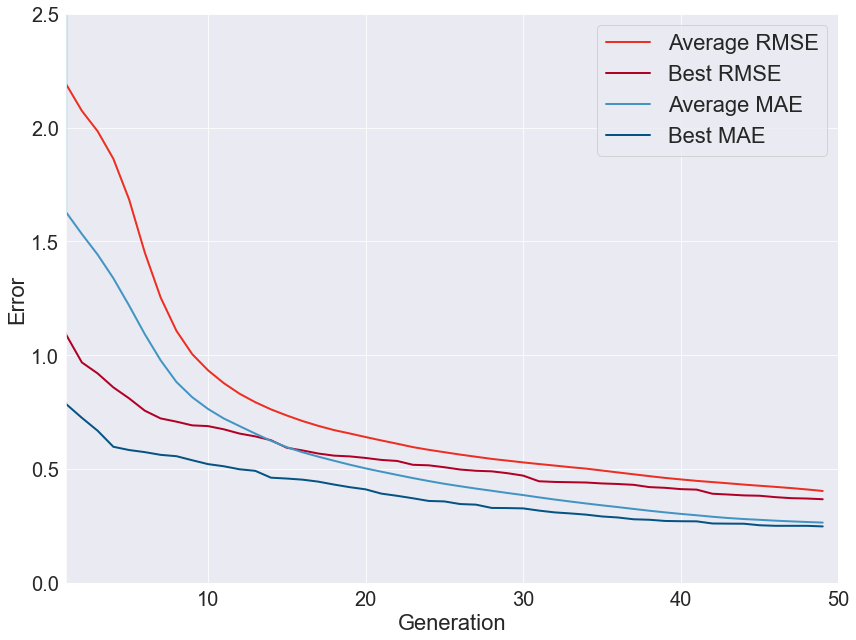

In [207]:
df_ga = pd.read_csv(datapath+'/GA-conv.csv',index_col=0)
# df_ga = df_ga.append(df_ga.iloc[49,:]).reset_index(drop=True)
modelnames = ['Average RMSE','Best RMSE','Average MAE','Best MAE']
colors = [redpalette[6],redpalette[8],bluepalette[5],bluepalette[8]]
fig,ax = plt.subplots(1)
for i in range(len(df_ga.columns)):
    ax.plot(np.arange(50),df_ga.iloc[0:,i],label=modelnames[i],color=colors[i])
    
ax.set_xlim((1,50))
ax.set_ylim((0,2.5))

ax.set_ylabel('Error')
ax.set_xlabel('Generation')
ax.legend()
fig.show()
fig.tight_layout()
plt.savefig(outputpath+'/GAconv.pdf',dpi=300)